In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os.path as path
import os
os.environ['OMP_NUM_THREADS'] = '2'

import lib.dist as dist
import lib.utils as utils


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
torch.__version__

'1.7.1'

In [2]:
b = 60
latent_dim = 8
h_node = 10
beta = 4
prior_dist = dist.Normal()
q_dist = dist.Normal()
t_len = 100

prefix = '../1_QMC/train' #'./Hirsch-Fye-QMC'
txt = np.loadtxt(prefix + f'/Bethe_14_beta{b:d}/field-2.10.dat')
s_tot, s_len = txt.shape
print("txt.shape =", s_tot, s_len)
s_train = 15
s_test = 15
s_num = 30
t_len = 100

U = np.array([0.01*i for i in range(100, 401)])
U_up, U_dn = [], []
for i, u in enumerate(U):
    if path.isfile(prefix + f'/Bethe_14_beta{b:d}/field-{u:.2f}.dat')==True: U_up.append(u)
    if path.isfile(prefix + f'/Bethe_41_beta{b:d}/field-{u:.2f}.dat')==True: U_dn.append(u)
U_up = np.array(U_up)
U_dn = np.array(U_dn)

txt.shape = 3000 288


In [ ]:
spin2d_up_test = np.zeros((len(U_up)*s_test, s_len))
spin2d_dn_test = np.zeros((len(U_dn)*s_test, s_len))
spin2d_up = np.zeros((len(U_up)*s_num, s_len))
spin2d_dn = np.zeros((len(U_dn)*s_num, s_len))
print("U_up, U_dn len =", len(U_up), len(U_dn))
print("spin2d_up_test size =", spin2d_up_test.shape[0], spin2d_up_test.shape[1])
print("spin2d_dn_test size =", spin2d_dn_test.shape[0], spin2d_dn_test.shape[1])

for i, u in enumerate(U_up):
    txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/field-{u:.2f}.dat')
    txt = 0.5*txt + 0.5
    #spin2d_up_train[i*s_train:(i+1)*s_train] = txt[:s_train,:]
    spin2d_up_test[i*s_test:(i+1)*s_test] = txt[-s_test:,:]
    spin2d_up[i*s_num:(i+1)*s_num] = txt
    del txt
for i, u in enumerate(U_dn):
    txt = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{b:d}/field-{u:.2f}.dat')
    txt = 0.5*txt + 0.5
    #spin2d_dn_train[i*s_train:(i+1)*s_train] = txt[:s_train,:]
    spin2d_dn_test[i*s_test:(i+1)*s_test] = txt[-s_test:,:]
    spin2d_dn[i*s_num:(i+1)*s_num] = txt
    del txt
spin2dtest = np.concatenate([spin2d_up_test, spin2d_dn_test])

spin2dtest = torch.Tensor(spin2dtest)
spin2d_up_test = torch.Tensor(spin2d_up_test)
spin2d_dn_test = torch.Tensor(spin2d_dn_test)
spin2d_up = torch.Tensor(spin2d_up)
spin2d_dn = torch.Tensor(spin2d_dn)


print("spin2dtest size =", spin2dtest.size())

In [3]:
num = 5

In [4]:
latent_dim = 8
h_node = 200

class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, h_node)
        self.b1 = nn.Linear(h_node, 1, bias=False)
        self.L2 = nn.Linear(h_node, output_dim)
        self.b2 = nn.Linear(output_dim, 1, bias=False)

        # setup the non-linearity
        self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, t_len, s_len)
        h = self.sig(self.L1(h))#+self.b1.weight)
        h = self.L2(h)#+self.b2.weight
        z = h.view(x.size(0), t_len, self.output_dim)
        return z

class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(h_node, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)
        self.L2 = nn.Linear(input_dim, h_node)
        self.b2 = nn.Linear(h_node, 1, bias=False)

        # setup the non-linearity
        self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1), z.size(2))
        h = self.sig(self.L2(h))#+self.b2.weight)
        mu_img = self.sig(self.L1(h))#+self.b1.weight)
        return mu_img

def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()
    
model_NN200 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_NN200.load_state_dict(torch.load(f'./frozen/VAE_NN200_{num:.0f}.pth'))



<All keys matched successfully>

In [5]:
latent_dim = 8
h_node = 100

class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, h_node)
        self.b1 = nn.Linear(h_node, 1, bias=False)
        self.L2 = nn.Linear(h_node, output_dim)
        self.b2 = nn.Linear(output_dim, 1, bias=False)

        # setup the non-linearity
        self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, t_len, s_len)
        h = self.sig(self.L1(h))#+self.b1.weight)
        h = self.L2(h)#+self.b2.weight
        z = h.view(x.size(0), t_len, self.output_dim)
        return z

class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(h_node, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)
        self.L2 = nn.Linear(input_dim, h_node)
        self.b2 = nn.Linear(h_node, 1, bias=False)

        # setup the non-linearity
        self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1), z.size(2))
        h = self.sig(self.L2(h))#+self.b2.weight)
        mu_img = self.sig(self.L1(h))#+self.b1.weight)
        return mu_img

def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()
    
model_NN100 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_NN100.load_state_dict(torch.load(f'./frozen/VAE_NN100_{num:.0f}.pth'))

<All keys matched successfully>

In [6]:
latent_dim = 8
h_node = 10

class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, h_node)
        self.b1 = nn.Linear(h_node, 1, bias=False)
        self.L2 = nn.Linear(h_node, output_dim)
        self.b2 = nn.Linear(output_dim, 1, bias=False)

        # setup the non-linearity
        self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, t_len, s_len)
        h = self.sig(self.L1(h))#+self.b1.weight)
        h = self.L2(h)#+self.b2.weight
        z = h.view(x.size(0), t_len, self.output_dim)
        return z

class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(h_node, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)
        self.L2 = nn.Linear(input_dim, h_node)
        self.b2 = nn.Linear(h_node, 1, bias=False)

        # setup the non-linearity
        self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        nn.init.xavier_normal_(self.L2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1), z.size(2))
        h = self.sig(self.L2(h))#+self.b2.weight)
        mu_img = self.sig(self.L1(h))#+self.b1.weight)
        return mu_img

def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()
    
model_NN10 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_NN10.load_state_dict(torch.load(f'./frozen/VAE_NN10_{num:.0f}.pth'))


<All keys matched successfully>

In [7]:
latent_dim = 8

class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        self.b1 = nn.Linear(output_dim, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        z = (self.act(self.L1(h)+self.b1.weight)).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

model_LR8 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR8.load_state_dict(torch.load(f'./frozen/VAE_LR8_{num:.0f}.pth'))


<All keys matched successfully>

In [8]:
latent_dim = 4
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        self.b1 = nn.Linear(output_dim, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        z = (self.act(self.L1(h)+self.b1.weight)).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

model_LR4 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR4.load_state_dict(torch.load(f'./frozen/VAE_LR4_{num:.0f}.pth'))


<All keys matched successfully>

In [9]:
latent_dim = 2
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        self.b1 = nn.Linear(output_dim, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, s_len)
        z = (self.act(self.L1(h)+self.b1.weight)).view(x.size(0), self.output_dim)
        return z
    
class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        self.b1 = nn.Linear(s_len, 1, bias=False)

        self.act = nn.Tanh()
        
        nn.init.xavier_normal_(self.L1.weight)
        self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1))
        mu_img = self.act(self.L1(h)+self.b1.weight)
        return mu_img
    
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)
        
### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

model_LR2 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR2.load_state_dict(torch.load(f'./frozen/VAE_LR2_{num:.0f}.pth'))


<All keys matched successfully>

In [ ]:
print(
model_NN200.encoder.L1.weight.data.max(), model_NN200.encoder.L1.weight.data.min(), \
model_NN200.decoder.L1.weight.data.max(), model_NN200.decoder.L1.weight.data.min())
print(
model_NN200.encoder.L2.weight.data.max(), model_NN200.encoder.L2.weight.data.min(), \
model_NN200.decoder.L2.weight.data.max(), model_NN200.decoder.L2.weight.data.min())
print('\n')

print(
model_NN100.encoder.L1.weight.data.max(), model_NN100.encoder.L1.weight.data.min(), \
model_NN100.decoder.L1.weight.data.max(), model_NN100.decoder.L1.weight.data.min())
print(
model_NN100.encoder.L2.weight.data.max(), model_NN100.encoder.L2.weight.data.min(), \
model_NN100.decoder.L2.weight.data.max(), model_NN100.decoder.L2.weight.data.min())
print('\n')

print(
model_NN10.encoder.L1.weight.data.max(), model_NN10.encoder.L1.weight.data.min(), \
model_NN10.decoder.L1.weight.data.max(), model_NN10.decoder.L1.weight.data.min())
print(
model_NN10.encoder.L2.weight.data.max(), model_NN10.encoder.L2.weight.data.min(), \
model_NN10.decoder.L2.weight.data.max(), model_NN10.decoder.L2.weight.data.min())


In [25]:
print(
model_LR8.encoder.L1.weight.data.max(), model_LR8.encoder.L1.weight.data.min(), \
model_LR8.decoder.L1.weight.data.max(), model_LR8.decoder.L1.weight.data.min())
print(
model_LR4.encoder.L1.weight.data.max(), model_LR4.encoder.L1.weight.data.min(), \
model_LR4.decoder.L1.weight.data.max(), model_LR4.decoder.L1.weight.data.min())
print(
model_LR2.encoder.L1.weight.data.max(), model_LR2.encoder.L1.weight.data.min(), \
model_LR2.decoder.L1.weight.data.max(), model_LR2.decoder.L1.weight.data.min())

tensor(0.1517) tensor(-0.1484) tensor(2.9232) tensor(-2.8750)
tensor(2.0906) tensor(-14.2595) tensor(2.8947) tensor(-3.0894)
tensor(0.0750) tensor(-0.3524) tensor(3.0493) tensor(0.3091)


In [19]:
LR2_zp_4 = torch.load('frozen/LR2_zp_4.dat')
LR4_zp_4 = torch.load('frozen/LR4_zp_4.dat')
LR8_zp_4 = torch.load('frozen/LR8_zp_4.dat')
NN10_zp_4 = torch.load('frozen/NN10_zp_4.dat')
NN100_zp_4 = torch.load('frozen/NN100_zp_4.dat')
NN200_zp_4 = torch.load('frozen/NN200_zp_4.dat')

LR2_zp_5 = torch.load('frozen/LR2_zp_5.dat')
LR4_zp_5 = torch.load('frozen/LR4_zp_5.dat')
LR8_zp_5 = torch.load('frozen/LR8_zp_5.dat')
NN10_zp_5 = torch.load('frozen/NN10_zp_5.dat')
NN100_zp_5 = torch.load('frozen/NN100_zp_5.dat')
NN200_zp_5 = torch.load('frozen/NN200_zp_5.dat')

zp_4 = [LR2_zp_4, LR4_zp_4, LR8_zp_4, NN10_zp_4, NN100_zp_4, NN200_zp_4]
zp_5 = [LR2_zp_5, LR4_zp_5, LR8_zp_5, NN10_zp_5, NN100_zp_5, NN200_zp_5]
zp_4.reverse(), zp_5.reverse()

(None, None)

In [32]:
UU = np.repeat(np.concatenate([U_up, U_dn]), 1500)

Text(1.1, 0.5, '')

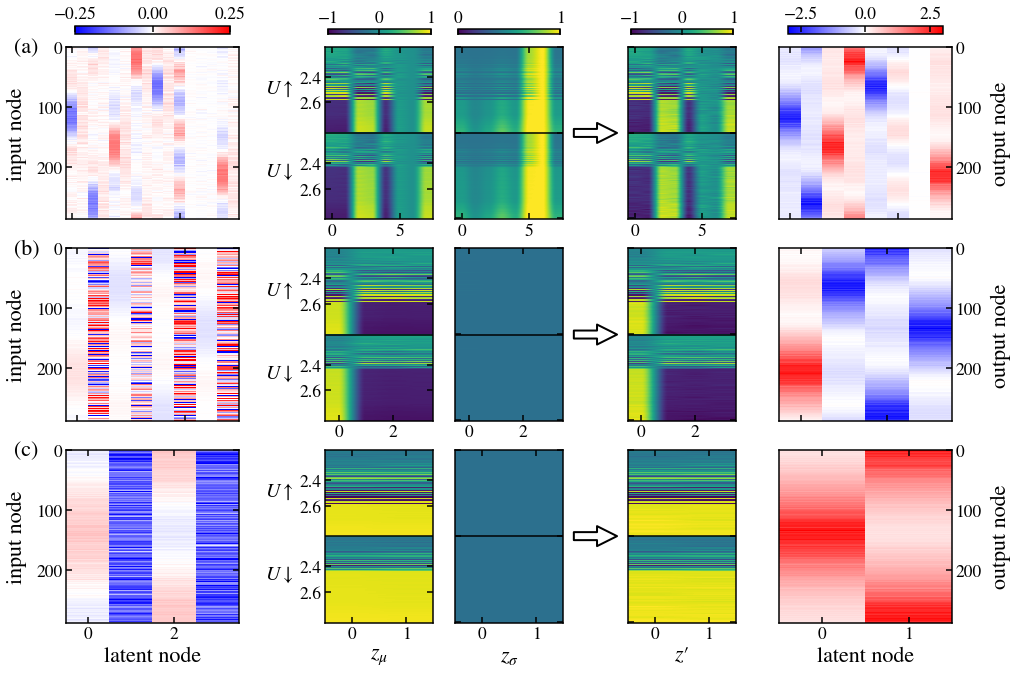

In [72]:
a = 1.1

ax30 = plt.axes([0.20+a, 1.4, 0.4, 0.6])
ax31 = plt.axes([1.85+a, 1.4, 0.4, 0.6])
ax40 = plt.axes([0.20+a, 0.7, 0.4, 0.6])
ax41 = plt.axes([1.85+a, 0.7, 0.4, 0.6])
ax50 = plt.axes([0.20+a, 0.0, 0.4, 0.6])
ax51 = plt.axes([1.85+a, 0.0, 0.4, 0.6])


ax30.set_xticklabels([])
ax31.set_xticklabels([])
ax40.set_xticklabels([])
ax41.set_xticklabels([])

ax31.yaxis.tick_right()
ax41.yaxis.tick_right()
ax51.yaxis.tick_right()

im30 = ax30.imshow(model_LR8.encoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=16/288, **{'vmin':-0.25, 'vmax':0.25})
im31 = ax31.imshow(model_LR8.decoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=8/288, **{'vmin':-3.0, 'vmax':3.0})
im40 = ax40.imshow(model_LR4.encoder.L1.weight.data.T*0.5, cmap='bwr', \
                   interpolation = 'nearest', aspect=8/288, **{'vmin':-0.4, 'vmax':0.4})
im41 = ax41.imshow(model_LR4.decoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=4/288, **{'vmin':-3.0, 'vmax':3.0})
im50 = ax50.imshow(model_LR2.encoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=4/288, **{'vmin':-0.3, 'vmax':0.3})
im51 = ax51.imshow(model_LR2.decoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=2/288, **{'vmin':-3.0, 'vmax':3.0})


ca30 = inset_axes(ax30, width="100%", height="5%", loc='lower center',
                   bbox_to_anchor=(0.05, 1.07, 0.9, 1), bbox_transform=ax30.transAxes, borderpad=0)
ca31 = inset_axes(ax31, width="100%", height="5%", loc='lower center',
                   bbox_to_anchor=(0.05, 1.07, 0.9, 1), bbox_transform=ax31.transAxes, borderpad=0)

cd = plt.colorbar(im30, cax = ca30, orientation='horizontal')
cd.ax.xaxis.tick_top()
cd = plt.colorbar(im31, cax = ca31, orientation='horizontal')
cd.ax.xaxis.tick_top()

ax30.set_ylabel('input node', fontsize=22, labelpad=9)
ax40.set_ylabel('input node', fontsize=22, labelpad=9)
ax50.set_ylabel('input node', fontsize=22, labelpad=9)
ax31.yaxis.set_label_position("right")
ax41.yaxis.set_label_position("right")
ax51.yaxis.set_label_position("right")
ax31.set_ylabel('output node', fontsize=22, labelpad=9)
ax41.set_ylabel('output node', fontsize=22, labelpad=9)
ax51.set_ylabel('output node', fontsize=22, labelpad=9)
ax50.set_xlabel('latent node', fontsize=22)
ax51.set_xlabel('latent node', fontsize=22)

plt.gcf().text(0.08+a, 2.0-0.02, '(a)', fontsize = 22)
plt.gcf().text(0.08+a, 1.3-0.02, '(b)', fontsize = 22)
plt.gcf().text(0.08+a, 0.6-0.02, '(c)', fontsize = 22)


axs0 = plt.axes([1.90, 0.0, 0.25, 0.6])
axs1 = plt.axes([2.20, 0.0, 0.25, 0.6])
axs2 = plt.axes([2.60, 0.0, 0.25, 0.6])
axs3 = plt.axes([1.90, 0.7, 0.25, 0.6])
axs4 = plt.axes([2.20, 0.7, 0.25, 0.6])
axs5 = plt.axes([2.60, 0.7, 0.25, 0.6])
axs6 = plt.axes([1.90, 1.4, 0.25, 0.6])
axs7 = plt.axes([2.20, 1.4, 0.25, 0.6])
axs8 = plt.axes([2.60, 1.4, 0.25, 0.6])
ax = [axs0, axs1, axs2, axs3, axs4, axs5, axs6, axs7, axs8]
        
for i, z_params in enumerate(zp_5[3:]):
    if z_params is LR2_zp_5: ldim = 2
    elif z_params is LR4_zp_5: ldim = 4
    else: ldim = 8
    
    mu = z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,0]
    im = ax[6-3*i+0].imshow(mu, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='hermite')
    if i==0:
        ca=inset_axes(ax[6-3*i+0], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+0].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()

    sig = np.exp(z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,1])
    im = ax[6-3*i+1].imshow(sig, **{'vmin':0.0, 'vmax':1},\
                      aspect='auto', interpolation='hermite')
    if i==0:
        ca=inset_axes(ax[6-3*i+1], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+1].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()
    
    sample = torch.randn(mu.shape)*sig + mu
    im = ax[6-3*i+2].imshow(sample, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='hermite')
    if i==0:
        ca=inset_axes(ax[6-3*i+2], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+2].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()
        
for i in range(3):
    ax[i].set_xticks([0,1])
    
for i, axs in enumerate(ax):
    axs.axhline(100500, c='k', lw='1.5')
    if i%3==0:
        a = [35000, 65000, 135500, 165500]
        axs.set_yticks(a)
        axs.set_yticklabels(UU[a])
        axs.annotate(r'$U\uparrow$', xy=(-0.43, 0.73), xycoords = 'axes fraction', fontsize = 20, ha = 'center')
        axs.annotate(r'$U\downarrow$', xy=(-0.43, 0.25), xycoords = 'axes fraction', fontsize = 20, ha = 'center')
    else:
        axs.set_yticklabels([])
    
ax[0].set_xlabel(r'$z_\mu$', fontsize = 22)
ax[1].set_xlabel(r'$z_\sigma$', fontsize = 22)
ax[2].set_xlabel(r'$z\prime$', fontsize = 22)

ax[1].annotate('', xy=(1.5,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':40, 'fc':'None', 'ec':'k'})
ax[4].annotate('', xy=(1.5,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':40, 'fc':'None', 'ec':'k'})
ax[7].annotate('', xy=(1.5,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':40, 'fc':'None', 'ec':'k'})


#plt.savefig('fig/fig_zparams.png')

#plt.savefig('fig/fig_weight_5.png', dpi = 200)

In [12]:
LR2_zp_5 = torch.load('frozen/LR2_zp_5.dat')
LR4_zp_5 = torch.load('frozen/LR4_zp_5.dat')
LR8_zp_5 = torch.load('frozen/LR8_zp_5.dat')

In [58]:
mu = LR2_zp_5.reshape(2010*100,2,2).detach().numpy()[:,:,0]
sig = np.exp(LR2_zp_5.reshape(2010*100,2,2).detach().numpy()[:,:,1])
sample = torch.randn(mu.shape)*sig + mu

(0.0, 1.7498752176761627)

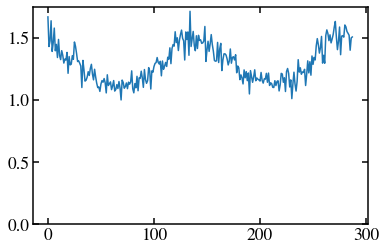

In [30]:
plt.plot(model_LR2.decoder.L1.weight.data.abs().mean(axis=1))
plt.ylim(0)

In [ ]:
plt.plot(model_LR4.decoder.L1.weight.data.abs())

In [ ]:
plt.plot(model_LR8.decoder.L1.weight.data.abs())

In [ ]:
a = 1.15
ax00 = plt.axes([0.25, 1.4, 0.4, 0.6])
ax01 = plt.axes([0.65, 1.4, 0.4, 0.6])
ax10 = plt.axes([0.25, 0.7, 0.4, 0.6])
ax11 = plt.axes([0.65, 0.7, 0.4, 0.6])
ax20 = plt.axes([0.25, 0.0, 0.4, 0.6])
ax21 = plt.axes([0.65, 0.0, 0.4, 0.6])

ax30 = plt.axes([0.25+a, 1.4, 0.4, 0.6])
ax31 = plt.axes([0.65+a, 1.4, 0.4, 0.6])
ax40 = plt.axes([0.25+a, 0.7, 0.4, 0.6])
ax41 = plt.axes([0.65+a, 0.7, 0.4, 0.6])
ax50 = plt.axes([0.25+a, 0.0, 0.4, 0.6])
ax51 = plt.axes([0.65+a, 0.0, 0.4, 0.6])

ax00.set_xticklabels([])
ax01.set_xticklabels([])
ax10.set_xticklabels([])
ax11.set_xticklabels([])
ax30.set_xticklabels([])
ax31.set_xticklabels([])
ax40.set_xticklabels([])
ax41.set_xticklabels([])

ax01.yaxis.tick_right()
ax11.yaxis.tick_right()
ax21.yaxis.tick_right()
ax31.yaxis.tick_right()
ax41.yaxis.tick_right()
ax51.yaxis.tick_right()

im00 = ax00.imshow(model_NN200.encoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/200, **{'vmin':-1.7, 'vmax':1.7})
im01 = ax01.imshow(model_NN200.decoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/200, **{'vmin':-3.4, 'vmax':3.4})
im10 = ax10.imshow(model_NN100.encoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/100, **{'vmin':-1.7, 'vmax':1.7})
im11 = ax11.imshow(model_NN100.decoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/100, **{'vmin':-3.4, 'vmax':3.4})
im20 = ax20.imshow(model_NN10.encoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/10, **{'vmin':-1.7, 'vmax':1.7})
im21 = ax21.imshow(model_NN10.decoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/10, **{'vmin':-3.4, 'vmax':3.4})

im30 = ax30.imshow(model_LR8.encoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/16, **{'vmin':-0.25, 'vmax':0.25})
im31 = ax31.imshow(model_LR8.decoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/8, **{'vmin':-3.0, 'vmax':3.0})
im40 = ax40.imshow(model_LR4.encoder.L1.weight.data*0.5, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/8, **{'vmin':-0.25, 'vmax':0.25})
im41 = ax41.imshow(model_LR4.decoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/4, **{'vmin':-3.0, 'vmax':3.0})
im50 = ax50.imshow(model_LR2.encoder.L1.weight.data, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/4, **{'vmin':-0.25, 'vmax':0.25})
im51 = ax51.imshow(model_LR2.decoder.L1.weight.data.T, cmap='bwr', \
                   interpolation = 'nearest', aspect=288/2, **{'vmin':-3.0, 'vmax':3.0})

ca00 = inset_axes(ax00, width="100%", height="5%", loc='lower center',
                   bbox_to_anchor=(0.05, 1.07, 0.9, 1), bbox_transform=ax00.transAxes, borderpad=0)
ca01 = inset_axes(ax01, width="100%", height="5%", loc='lower center',
                   bbox_to_anchor=(0.05, 1.07, 0.9, 1), bbox_transform=ax01.transAxes, borderpad=0)
#ca21 = inset_axes(ax21, width="5%", height="100%", loc='center left',
#                   bbox_to_anchor=(1.15, 0.00, 0.8, 1), bbox_transform=ax21.transAxes, borderpad=0)
ca30 = inset_axes(ax30, width="100%", height="5%", loc='lower center',
                   bbox_to_anchor=(0.05, 1.07, 0.9, 1), bbox_transform=ax30.transAxes, borderpad=0)
ca31 = inset_axes(ax31, width="100%", height="5%", loc='lower center',
                   bbox_to_anchor=(0.05, 1.07, 0.9, 1), bbox_transform=ax31.transAxes, borderpad=0)
#ca40 = inset_axes(ax40, width="5%", height="100%", loc='center left',
#                   bbox_to_anchor=(-.25, 0., 0.8, 1), bbox_transform=ax40.transAxes, borderpad=0)
#ca41 = inset_axes(ax41, width="5%", height="100%", loc='center left',
#                   bbox_to_anchor=(1.20, 0., 0.8, 1), bbox_transform=ax41.transAxes, borderpad=0)
#ca50 = inset_axes(ax50, width="5%", height="100%", loc='center left',
#                   bbox_to_anchor=(-.25, 0., 0.8, 1), bbox_transform=ax50.transAxes, borderpad=0)
#ca51 = inset_axes(ax51, width="5%", height="100%", loc='center left',
#                   bbox_to_anchor=(1.20, 0., 0.8, 1), bbox_transform=ax51.transAxes, borderpad=0)

cd = plt.colorbar(im00, cax = ca00, orientation='horizontal')
cd.ax.xaxis.tick_top()
cd = plt.colorbar(im01, cax = ca01, orientation='horizontal')
cd.ax.xaxis.tick_top()
#cd = plt.colorbar(im21, cax = ca21)
cd = plt.colorbar(im30, cax = ca30, orientation='horizontal')
cd.ax.xaxis.tick_top()
cd = plt.colorbar(im31, cax = ca31, orientation='horizontal')
cd.ax.xaxis.tick_top()

ax00.set_ylabel('hidden node', fontsize=22, labelpad=9)
ax10.set_ylabel('hidden node', fontsize=22, labelpad=19)
ax20.set_ylabel('hidden node', fontsize=22, labelpad=19)
ax20.set_xlabel('input node', fontsize=22)
ax21.set_xlabel('output node', fontsize=22)

ax30.set_ylabel('latent node', fontsize=22, labelpad=9)
ax40.set_ylabel('latent node', fontsize=22, labelpad=19)
ax50.set_ylabel('latent node', fontsize=22, labelpad=19)
ax50.set_xlabel('input node', fontsize=22)
ax51.set_xlabel('output node', fontsize=22)

plt.gcf().text(0.08, 2.0-0.02, '(a)', fontsize = 22)
plt.gcf().text(0.08, 1.3-0.02, '(b)', fontsize = 22)
plt.gcf().text(0.08, 0.6-0.02, '(c)', fontsize = 22)
plt.gcf().text(0.08+a, 2.0-0.02, '(d)', fontsize = 22)
plt.gcf().text(0.08+a, 1.3-0.02, '(e)', fontsize = 22)
plt.gcf().text(0.08+a, 0.6-0.02, '(f)', fontsize = 22)

plt.savefig('fig/fig_weight_5.pdf')

## TEST

# PCA

In [10]:
NN200_zp = torch.load('frozen/NN200_zp_5.dat')
NN200_zp_up = torch.load('frozen/NN200_zp_up_5.dat')
NN200_zp_dn = torch.load('frozen/NN200_zp_dn_5.dat')

NN100_zp = torch.load('frozen/NN100_zp_5.dat')
NN100_zp_up = torch.load('frozen/NN100_zp_up_5.dat')
NN100_zp_dn = torch.load('frozen/NN100_zp_dn_5.dat')

NN10_zp = torch.load('frozen/NN10_zp_5.dat')
NN10_zp_up = torch.load('frozen/NN10_zp_up_5.dat')
NN10_zp_dn = torch.load('frozen/NN10_zp_dn_5.dat')

LR8_zp = torch.load('frozen/LR8_zp_5.dat')
LR8_zp_up = torch.load('frozen/LR8_zp_up_5.dat')
LR8_zp_dn = torch.load('frozen/LR8_zp_dn_5.dat')

LR4_zp = torch.load('frozen/LR4_zp_5.dat')
LR4_zp_up = torch.load('frozen/LR4_zp_up_5.dat')
LR4_zp_dn = torch.load('frozen/LR4_zp_dn_5.dat')

LR2_zp = torch.load('frozen/LR2_zp_5.dat')
LR2_zp_up = torch.load('frozen/LR2_zp_up_5.dat')
LR2_zp_dn = torch.load('frozen/LR2_zp_dn_5.dat')

In [11]:
NN200_mu_up = NN200_zp_up.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
NN200_logsig_up = NN200_zp_up.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
NN200_var_up = np.exp(NN200_logsig_up * 2)
NN200_mu_dn = NN200_zp_dn.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
NN200_logsig_dn = NN200_zp_dn.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
NN200_var_dn = np.exp(NN200_logsig_dn * 2)
NN200_ens_mu_up = np.zeros((len(U_up), 8))
NN200_ens_logsig_up = np.zeros((len(U_up), 8))
NN200_ens_mu_dn = np.zeros((len(U_dn), 8))
NN200_ens_logsig_dn = np.zeros((len(U_dn), 8))

NN100_mu_up = NN100_zp_up.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
NN100_logsig_up = NN100_zp_up.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
NN100_var_up = np.exp(NN100_logsig_up * 2)
NN100_mu_dn = NN100_zp_dn.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
NN100_logsig_dn = NN100_zp_dn.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
NN100_var_dn = np.exp(NN100_logsig_dn * 2)
NN100_ens_mu_up = np.zeros((len(U_up), 8))
NN100_ens_logsig_up = np.zeros((len(U_up), 8))
NN100_ens_mu_dn = np.zeros((len(U_dn), 8))
NN100_ens_logsig_dn = np.zeros((len(U_dn), 8))

NN10_mu_up = NN10_zp_up.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
NN10_logsig_up = NN10_zp_up.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
NN10_var_up = np.exp(NN10_logsig_up * 2)
NN10_mu_dn = NN10_zp_dn.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
NN10_logsig_dn = NN10_zp_dn.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
NN10_var_dn = np.exp(NN10_logsig_dn * 2)
NN10_ens_mu_up = np.zeros((len(U_up), 8))
NN10_ens_logsig_up = np.zeros((len(U_up), 8))
NN10_ens_mu_dn = np.zeros((len(U_dn), 8))
NN10_ens_logsig_dn = np.zeros((len(U_dn), 8))

LR8_mu_up = LR8_zp_up.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
LR8_logsig_up = LR8_zp_up.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
LR8_var_up = np.exp(LR8_logsig_up * 2)
LR8_mu_dn = LR8_zp_dn.reshape(1005*100,8,2)[:, :, 0].detach().numpy()
LR8_logsig_dn = LR8_zp_dn.reshape(1005*100,8,2)[:, :, 1].detach().numpy()
LR8_var_dn = np.exp(LR8_logsig_dn * 2)
LR8_ens_mu_up = np.zeros((len(U_up), 8))
LR8_ens_logsig_up = np.zeros((len(U_up), 8))
LR8_ens_mu_dn = np.zeros((len(U_dn), 8))
LR8_ens_logsig_dn = np.zeros((len(U_dn), 8))

LR4_mu_up = LR4_zp_up.reshape(1005*100,4,2)[:, :, 0].detach().numpy()
LR4_logsig_up = LR4_zp_up.reshape(1005*100,4,2)[:, :, 1].detach().numpy()
LR4_var_up = np.exp(LR4_logsig_up * 2)
LR4_mu_dn = LR4_zp_dn.reshape(1005*100,4,2)[:, :, 0].detach().numpy()
LR4_logsig_dn = LR4_zp_dn.reshape(1005*100,4,2)[:, :, 1].detach().numpy()
LR4_var_dn = np.exp(LR4_logsig_dn * 2)
LR4_ens_mu_up = np.zeros((len(U_up), 4))
LR4_ens_logsig_up = np.zeros((len(U_up), 4))
LR4_ens_mu_dn = np.zeros((len(U_dn), 4))
LR4_ens_logsig_dn = np.zeros((len(U_dn), 4))

LR2_mu_up = LR2_zp_up.reshape(1005*100,2,2)[:, :, 0].detach().numpy()
LR2_logsig_up = LR2_zp_up.reshape(1005*100,2,2)[:, :, 1].detach().numpy()
LR2_var_up = np.exp(LR2_logsig_up * 2)
LR2_mu_dn = LR2_zp_dn.reshape(1005*100,2,2)[:, :, 0].detach().numpy()
LR2_logsig_dn = LR2_zp_dn.reshape(1005*100,2,2)[:, :, 1].detach().numpy()
LR2_var_dn = np.exp(LR2_logsig_dn * 2)
LR2_ens_mu_up = np.zeros((len(U_up), 2))
LR2_ens_logsig_up = np.zeros((len(U_up), 2))
LR2_ens_mu_dn = np.zeros((len(U_dn), 2))
LR2_ens_logsig_dn = np.zeros((len(U_dn), 2))


for i in range(len(U_up)):
    NN200_ens_mu_up[i] = np.average(NN200_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    NN200_ens_logsig_up[i] = np.average(NN200_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    NN100_ens_mu_up[i] = np.average(NN100_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    NN100_ens_logsig_up[i] = np.average(NN100_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    NN10_ens_mu_up[i] = np.average(NN10_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    NN10_ens_logsig_up[i] = np.average(NN10_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    LR8_ens_mu_up[i] = np.average(LR8_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    LR8_ens_logsig_up[i] = np.average(LR8_zp_up.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    LR4_ens_mu_up[i] = np.average(LR4_zp_up.reshape(1005*100,4,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    LR4_ens_logsig_up[i] = np.average(LR4_zp_up.reshape(1005*100,4,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    LR2_ens_mu_up[i] = np.average(LR2_zp_up.reshape(1005*100,2,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    LR2_ens_logsig_up[i] = np.average(LR2_zp_up.reshape(1005*100,2,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
for i in range(len(U_dn)):
    NN200_ens_mu_dn[i] = np.average(NN200_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    NN200_ens_logsig_dn[i] = np.average(NN200_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    NN100_ens_mu_dn[i] = np.average(NN100_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    NN100_ens_logsig_dn[i] = np.average(NN100_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    NN10_ens_mu_dn[i] = np.average(NN10_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    NN10_ens_logsig_dn[i] = np.average(NN10_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    LR8_ens_mu_dn[i] = np.average(LR8_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    LR8_ens_logsig_dn[i] = np.average(LR8_zp_dn.reshape(1005*100,8,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    LR4_ens_mu_dn[i] = np.average(LR4_zp_dn.reshape(1005*100,4,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    LR4_ens_logsig_dn[i] = np.average(LR4_zp_dn.reshape(1005*100,4,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    LR2_ens_mu_dn[i] = np.average(LR2_zp_dn.reshape(1005*100,2,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 0].detach().numpy(), axis=0)
    LR2_ens_logsig_dn[i] = np.average(LR2_zp_dn.reshape(1005*100,2,2)[i*s_test*t_len:(i+1)*s_test*t_len, :, 1].detach().numpy(), axis=0)
    
NN200_ens_var_up = np.exp(NN200_ens_logsig_up * 2)
NN200_ens_var_dn = np.exp(NN200_ens_logsig_dn * 2)
NN100_ens_var_up = np.exp(NN100_ens_logsig_up * 2)
NN100_ens_var_dn = np.exp(NN100_ens_logsig_dn * 2)
NN10_ens_var_up = np.exp(NN10_ens_logsig_up * 2)
NN10_ens_var_dn = np.exp(NN10_ens_logsig_dn * 2)
LR8_ens_var_up = np.exp(LR8_ens_logsig_up * 2)
LR8_ens_var_dn = np.exp(LR8_ens_logsig_dn * 2)
LR4_ens_var_up = np.exp(LR4_ens_logsig_up * 2)
LR4_ens_var_dn = np.exp(LR4_ens_logsig_dn * 2)
LR2_ens_var_up = np.exp(LR2_ens_logsig_up * 2)
LR2_ens_var_dn = np.exp(LR2_ens_logsig_dn * 2)

NN200_ens_mu = np.concatenate([NN200_ens_mu_up, NN200_ens_mu_dn])
NN200_ens_var = np.concatenate([NN200_ens_var_up, NN200_ens_var_dn])
NN100_ens_mu = np.concatenate([NN100_ens_mu_up, NN100_ens_mu_dn])
NN100_ens_var = np.concatenate([NN100_ens_var_up, NN100_ens_var_dn])
NN10_ens_mu = np.concatenate([NN10_ens_mu_up, NN10_ens_mu_dn])
NN10_ens_var = np.concatenate([NN10_ens_var_up, NN10_ens_var_dn])
LR8_ens_mu = np.concatenate([LR8_ens_mu_up, LR8_ens_mu_dn])
LR8_ens_var = np.concatenate([LR8_ens_var_up, LR8_ens_var_dn])
LR4_ens_mu = np.concatenate([LR4_ens_mu_up, LR4_ens_mu_dn])
LR4_ens_var = np.concatenate([LR4_ens_var_up, LR4_ens_var_dn])
LR2_ens_mu = np.concatenate([LR2_ens_mu_up, LR2_ens_mu_dn])
LR2_ens_var = np.concatenate([LR2_ens_var_up, LR2_ens_var_dn])

In [12]:
NN200_pca1 = PCA(n_components=2)
NN200_pca1.fit(NN200_ens_mu)
NN200_pca_mu_up = NN200_pca1.transform(NN200_ens_mu_up)
NN200_pca_mu_dn = NN200_pca1.transform(NN200_ens_mu_dn)
NN200_pca2 = PCA(n_components=2)
NN200_pca2.fit(NN200_ens_var)
NN200_pca_var_up = NN200_pca2.transform(NN200_ens_var_up)
NN200_pca_var_dn = NN200_pca2.transform(NN200_ens_var_dn)

NN100_pca1 = PCA(n_components=2)
NN100_pca1.fit(NN100_ens_mu)
NN100_pca_mu_up = NN100_pca1.transform(NN100_ens_mu_up)
NN100_pca_mu_dn = NN100_pca1.transform(NN100_ens_mu_dn)
NN100_pca2 = PCA(n_components=2)
NN100_pca2.fit(NN100_ens_var)
NN100_pca_var_up = NN100_pca2.transform(NN100_ens_var_up)
NN100_pca_var_dn = NN100_pca2.transform(NN100_ens_var_dn)

NN10_pca1 = PCA(n_components=2)
NN10_pca1.fit(NN10_ens_mu)
NN10_pca_mu_up = NN10_pca1.transform(NN10_ens_mu_up)
NN10_pca_mu_dn = NN10_pca1.transform(NN10_ens_mu_dn)
NN10_pca2 = PCA(n_components=2)
NN10_pca2.fit(NN10_ens_var)
NN10_pca_var_up = NN10_pca2.transform(NN10_ens_var_up)
NN10_pca_var_dn = NN10_pca2.transform(NN10_ens_var_dn)

LR8_pca1 = PCA(n_components=2)
LR8_pca1.fit(LR8_ens_mu)
LR8_pca_mu_up = LR8_pca1.transform(LR8_ens_mu_up)
LR8_pca_mu_dn = LR8_pca1.transform(LR8_ens_mu_dn)
LR8_pca2 = PCA(n_components=2)
LR8_pca2.fit(LR8_ens_var)
LR8_pca_var_up = LR8_pca2.transform(LR8_ens_var_up)
LR8_pca_var_dn = LR8_pca2.transform(LR8_ens_var_dn)

LR4_pca1 = PCA(n_components=2)
LR4_pca1.fit(LR4_ens_mu)
LR4_pca_mu_up = LR4_pca1.transform(LR4_ens_mu_up)
LR4_pca_mu_dn = LR4_pca1.transform(LR4_ens_mu_dn)
LR4_pca2 = PCA(n_components=2)
LR4_pca2.fit(LR4_ens_var)
LR4_pca_var_up = LR4_pca2.transform(LR4_ens_var_up)
LR4_pca_var_dn = LR4_pca2.transform(LR4_ens_var_dn)

LR2_pca1 = PCA(n_components=2)
LR2_pca1.fit(LR2_ens_mu)
LR2_pca_mu_up = LR2_pca1.transform(LR2_ens_mu_up)
LR2_pca_mu_dn = LR2_pca1.transform(LR2_ens_mu_dn)
LR2_pca2 = PCA(n_components=2)
LR2_pca2.fit(LR2_ens_var)
LR2_pca_var_up = LR2_pca2.transform(LR2_ens_var_up)
LR2_pca_var_dn = LR2_pca2.transform(LR2_ens_var_dn)

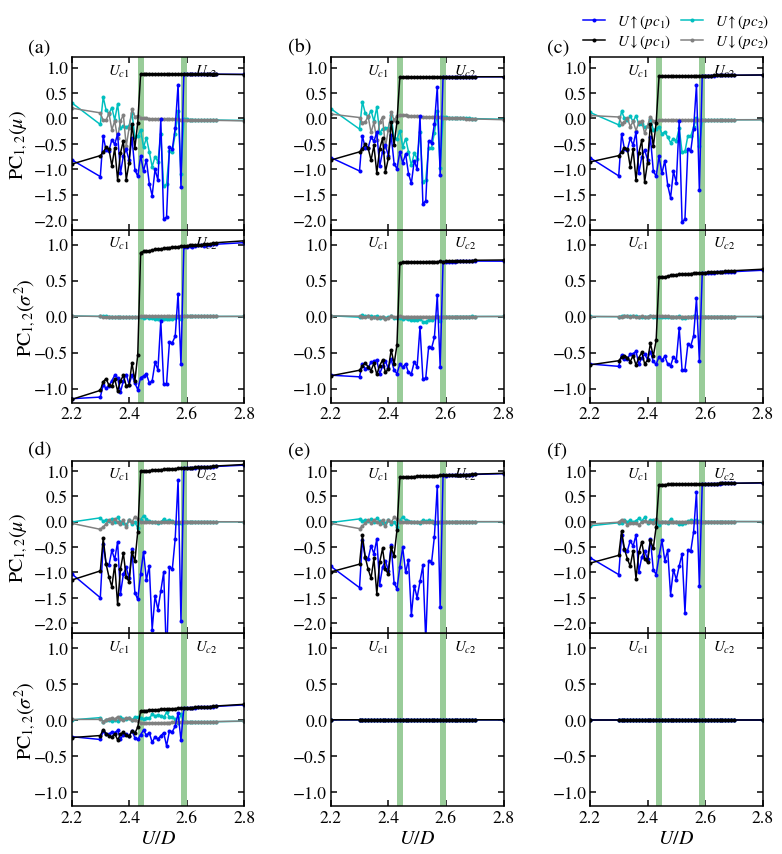

In [17]:
U_c1, U_c2 = 2.44, 2.59
UU = np.concatenate([U_up, U_dn])

ax00 = plt.axes([0.0, 1.4, 0.4, 0.6])
ax01 = plt.axes([0.0, 2.0, 0.4, 0.6])
ax10 = plt.axes([0.6, 1.4, 0.4, 0.6])
ax11 = plt.axes([0.6, 2.0, 0.4, 0.6])
ax20 = plt.axes([1.2, 1.4, 0.4, 0.6])
ax21 = plt.axes([1.2, 2.0, 0.4, 0.6])

ax30 = plt.axes([0.0, 0.0, 0.4, 0.6])
ax31 = plt.axes([0.0, 0.6, 0.4, 0.6])
ax40 = plt.axes([0.6, 0.0, 0.4, 0.6])
ax41 = plt.axes([0.6, 0.6, 0.4, 0.6])
ax50 = plt.axes([1.2, 0.0, 0.4, 0.6])
ax51 = plt.axes([1.2, 0.6, 0.4, 0.6])
axx = [ax00, ax01, ax10, ax11, ax20, ax21, ax30, ax31, ax40, ax41, ax50, ax51]

for i, ax in enumerate(axx):
    ax.axvline(U_c1, c='#99cc99', lw='6')
    ax.axvline(U_c2, c='#99cc99', lw='6')
    ax.set_xlim(2.2, 2.8)
    ax.annotate(r'$U_{c1}$', xy = (0.275, 0.9), xycoords = 'axes fraction', fontsize=15, ha='center')
    ax.annotate(r'$U_{c2}$', xy = (0.78, 0.9), xycoords = 'axes fraction', fontsize=15, ha='center')
    if i%2==1: 
        ax.set_xticklabels([])
    
ax00.plot(U_up, -NN200_pca_var_up[:,1], 'c.-')
ax00.plot(U_dn, -NN200_pca_var_dn[:,1], '.-', color = '#808080')
ax00.plot(U_up, -NN200_pca_var_up[:,0], 'b.-')
ax00.plot(U_dn, -NN200_pca_var_dn[:,0], 'k.-')
ax00.set_ylabel(r'PC$_{1,2}(\sigma^2)$', fontsize = 20, labelpad = -5)
ax01.plot(U_up, -NN200_pca_mu_up[:,1], 'c.-')
ax01.plot(U_dn, -NN200_pca_mu_dn[:,1], '.-', color = '#808080')
ax01.plot(U_up, -NN200_pca_mu_up[:,0], 'b.-')
ax01.plot(U_dn, -NN200_pca_mu_dn[:,0], 'k.-')
ax01.set_ylabel(r'PC$_{1,2}(\mu)$', fontsize = 20)

ax10.plot(U_up, -NN100_pca_var_up[:,1], 'c.-')
ax10.plot(U_dn, -NN100_pca_var_dn[:,1], '.-', color = '#808080')
ax10.plot(U_up, -NN100_pca_var_up[:,0], 'b.-')
ax10.plot(U_dn, -NN100_pca_var_dn[:,0], 'k.-')
ax11.plot(U_up, -NN100_pca_mu_up[:,1], 'c.-')
ax11.plot(U_dn, -NN100_pca_mu_dn[:,1], '.-', color = '#808080')
ax11.plot(U_up, -NN100_pca_mu_up[:,0], 'b.-')
ax11.plot(U_dn, -NN100_pca_mu_dn[:,0], 'k.-')

ax20.plot(U_up, -NN10_pca_var_up[:,1], 'c.-')
ax20.plot(U_dn, -NN10_pca_var_dn[:,1], '.-', color = '#808080')
ax20.plot(U_up, -NN10_pca_var_up[:,0], 'b.-')
ax20.plot(U_dn, -NN10_pca_var_dn[:,0], 'k.-')
ax21.plot(U_up, -NN10_pca_mu_up[:,1], 'c.-', label=r'$U \uparrow (pc_2)$')
ax21.plot(U_dn, -NN10_pca_mu_dn[:,1], '.-', color = '#808080', label=r'$U \downarrow (pc_2)$')
ax21.plot(U_up, -NN10_pca_mu_up[:,0], 'b.-', label=r'$U \uparrow (pc_1)$')
ax21.plot(U_dn, -NN10_pca_mu_dn[:,0], 'k.-', label=r'$U \downarrow (pc_1)$')

ax30.plot(U_up, LR8_pca_var_up[:,1], 'c.-')
ax30.plot(U_dn, LR8_pca_var_dn[:,1], '.-', color = '#808080')
ax30.plot(U_up, LR8_pca_var_up[:,0], 'b.-')
ax30.plot(U_dn, LR8_pca_var_dn[:,0], 'k.-')
ax30.set_xlabel(r'$U/D$', fontsize = 20)
ax30.set_ylabel(r'PC$_{1,2}(\sigma^2)$', fontsize = 20, labelpad = -5)
ax31.plot(U_up, -LR8_pca_mu_up[:,1], 'c.-')
ax31.plot(U_dn, -LR8_pca_mu_dn[:,1], '.-', color = '#808080')
ax31.plot(U_up, -LR8_pca_mu_up[:,0], 'b.-')
ax31.plot(U_dn, -LR8_pca_mu_dn[:,0], 'k.-')
ax31.set_ylabel(r'PC$_{1,2}(\mu)$', fontsize = 20)

ax40.plot(U_up, -LR4_pca_var_up[:,1], 'c.-')
ax40.plot(U_dn, -LR4_pca_var_dn[:,1], '.-', color = '#808080')
ax40.plot(U_up, -LR4_pca_var_up[:,0], 'b.-')
ax40.plot(U_dn, -LR4_pca_var_dn[:,0], 'k.-')
ax40.set_xlabel(r'$U/D$', fontsize = 20)
ax41.plot(U_up, -LR4_pca_mu_up[:,1], 'c.-')
ax41.plot(U_dn, -LR4_pca_mu_dn[:,1], '.-', color = '#808080')
ax41.plot(U_up, -LR4_pca_mu_up[:,0], 'b.-')
ax41.plot(U_dn, -LR4_pca_mu_dn[:,0], 'k.-')


ax50.plot(U_up, -LR2_pca_var_up[:,1], 'c.-')
ax50.plot(U_dn, -LR2_pca_var_dn[:,1], '.-', color = '#808080')
ax50.plot(U_up, -LR2_pca_var_up[:,0], 'b.-')
ax50.plot(U_dn, -LR2_pca_var_dn[:,0], 'k.-')
ax50.set_xlabel(r'$U/D$', fontsize = 20)
ax51.plot(U_up, -LR2_pca_mu_up[:,1], 'c.-')
ax51.plot(U_dn, -LR2_pca_mu_dn[:,1], '.-', color = '#808080')
ax51.plot(U_up, -LR2_pca_mu_up[:,0], 'b.-')
ax51.plot(U_dn, -LR2_pca_mu_dn[:,0], 'k.-')

for i, ax in enumerate(axx):
    if i%2==1: 
        ax.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0])
        ax.set_ylim(-2.2, 1.2)
    if i%2==0:
        ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
        ax.set_ylim(-1.2, 1.2)
plt.gcf().text(-0.1, 2.62, '(a)', fontsize=20)
plt.gcf().text(0.5, 2.62, '(b)', fontsize=20)
plt.gcf().text(1.1, 2.62, '(c)', fontsize=20)
plt.gcf().text(-0.1, 1.22, '(d)', fontsize=20)
plt.gcf().text(0.5, 1.22, '(e)', fontsize=20)
plt.gcf().text(1.1, 1.22, '(f)', fontsize=20)

hs, ls = ax21.get_legend_handles_labels()
ax21.legend([hs[2], hs[3], hs[0], hs[1]], [ls[2], ls[3], ls[0], ls[1]], bbox_to_anchor=(0.5, 1.15),\
           loc='center', labelspacing=0.15, columnspacing=0.6, handlelength = 1.5, fontsize=15, ncol=2)

plt.savefig('fig/fig_pca_5.pdf')

# reconstruction

In [ ]:


b = 60

w, gr, gi = np.loadtxt(f'../3_VAE_recon/test_NN10/Bethe_14_beta{b:d}/Giwn_recon-2.00.dat', \
                       unpack=True, dtype='float64')
s_num, s_len = txt.shape
print("txt.shape =", s_num, s_len)

U = np.array([0.01*i for i in range(100, 401)])
Ur_up, Ur_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../3_VAE_recon/test_NN10/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat')==True: Ur_up.append(u)
    if path.isfile(f'../3_VAE_recon/test_NN10/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat')==True: Ur_dn.append(u)
Ur_up = np.array(Ur_up)
Ur_dn = np.array(Ur_dn)
Ur_len = len(Ur_up)+len(Ur_dn)
UUr = np.concatenate([Ur_up, Ur_dn])

gup = np.zeros((7, len(Ur_up), 180))
gdn = np.zeros((7, len(Ur_dn), 180))
for i,u in enumerate(Ur_up):
    gup[0,i] = np.loadtxt(f'../3_VAE_recon/test_NN200/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gup[1,i] = np.loadtxt(f'../3_VAE_recon/test_NN100/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gup[2,i] = np.loadtxt(f'../3_VAE_recon/test_NN10/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gup[3,i] = np.loadtxt(f'../3_VAE_recon/test_LR8/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gup[4,i] = np.loadtxt(f'../3_VAE_recon/test_LR4/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gup[5,i] = np.loadtxt(f'../3_VAE_recon/test_LR2/Bethe_14_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gup[6,i] = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/Giwn-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
for i,u in enumerate(Ur_dn):
    gdn[0,i] = np.loadtxt(f'../3_VAE_recon/test_NN200/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gdn[1,i] = np.loadtxt(f'../3_VAE_recon/test_NN100/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gdn[2,i] = np.loadtxt(f'../3_VAE_recon/test_NN10/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gdn[3,i] = np.loadtxt(f'../3_VAE_recon/test_LR8/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gdn[4,i] = np.loadtxt(f'../3_VAE_recon/test_LR4/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gdn[5,i] = np.loadtxt(f'../3_VAE_recon/test_LR2/Bethe_41_beta{b:d}/Giwn_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    gdn[6,i] = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{b:d}/Giwn-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[2]
    

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15), sharey=True)
for i,u in enumerate(Ur_up):
    for j in range(6):
        if np.max(gup[j,i])>3: continue
        ax[int(i/3), i%3].plot(w, gup[j,i], '--', label=f'{j}th')
    ax[int(i/3), i%3].plot(w, gup[6,i], 'k.-', ms=3)
    ax[int(i/3), i%3].set_ylim(-1.5, 0.1)
    ax[int(i/3), i%3].legend(loc='lower right', ncol=2)
    ax[int(i/3), i%3].set_title(f'U={u:.2f}', fontsize=17)

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15), sharey=True)
for i,u in enumerate(Ur_dn):
    for j in np.arange(6):
        if np.max(gdn[j,i])>3: continue
        ax[int(i/3), i%3].plot(w, gdn[j,i], '--', label=f'{j}th')
    ax[int(i/3), i%3].plot(w, gdn[6,i], 'k.-', ms=3)
    ax[int(i/3), i%3].set_ylim(-1.5, 0.1)
    ax[int(i/3), i%3].legend(loc='lower right', ncol=2)
    ax[int(i/3), i%3].set_title(f'U={u:.2f}', fontsize=17)

In [ ]:
b = 60

w, gr, gi = np.loadtxt(f'../3_VAE_recon/test_NN10/Bethe_14_beta{b:d}/Gtau_recon-2.00.dat', \
                       unpack=True, dtype='float64')
s_num, s_len = txt.shape
print("txt.shape =", s_num, s_len)

U = np.array([0.01*i for i in range(100, 401)])
Ur_up, Ur_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../3_VAE_recon/test_NN10/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat')==True: Ur_up.append(u)
    if path.isfile(f'../3_VAE_recon/test_NN10/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat')==True: Ur_dn.append(u)
Ur_up = np.array(Ur_up)
Ur_dn = np.array(Ur_dn)
Ur_len = len(Ur_up)+len(Ur_dn)
UUr = np.concatenate([Ur_up, Ur_dn])

gup = np.zeros((7, len(Ur_up), 289))
gdn = np.zeros((7, len(Ur_dn), 289))
for i,u in enumerate(Ur_up):
    gup[0,i] = np.loadtxt(f'../3_VAE_recon/test_NN200/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gup[1,i] = np.loadtxt(f'../3_VAE_recon/test_NN100/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gup[2,i] = np.loadtxt(f'../3_VAE_recon/test_NN10/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gup[3,i] = np.loadtxt(f'../3_VAE_recon/test_LR8/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gup[4,i] = np.loadtxt(f'../3_VAE_recon/test_LR4/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gup[5,i] = np.loadtxt(f'../3_VAE_recon/test_LR2/Bethe_14_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gup[6,i] = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/Gtau-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
for i,u in enumerate(Ur_dn):
    gdn[0,i] = np.loadtxt(f'../3_VAE_recon/test_NN200/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gdn[1,i] = np.loadtxt(f'../3_VAE_recon/test_NN100/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gdn[2,i] = np.loadtxt(f'../3_VAE_recon/test_NN10/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gdn[3,i] = np.loadtxt(f'../3_VAE_recon/test_LR8/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gdn[4,i] = np.loadtxt(f'../3_VAE_recon/test_LR4/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gdn[5,i] = np.loadtxt(f'../3_VAE_recon/test_LR2/Bethe_41_beta{b:d}/Gtau_recon-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    gdn[6,i] = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{b:d}/Gtau-{u:.2f}.dat',\
                                                                         unpack=True, dtype='float64')[1]
    

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15), sharey=True)
for i,u in enumerate(Ur_up):
    for j in range(6):
        #if np.max(gup[j,i])>3: continue
        ax[int(i/3), i%3].plot(w, gup[j,i], '--', label=f'{j}th')
    ax[int(i/3), i%3].plot(w, gup[6,i], 'k.-', ms=3)
    ax[int(i/3), i%3].set_ylim(-0.5, 0.1)
    ax[int(i/3), i%3].legend(loc='lower right', ncol=2)
    ax[int(i/3), i%3].set_title(f'U={u:.2f}', fontsize=17)

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15), sharey=True)
for i,u in enumerate(Ur_dn):
    for j in np.arange(6):
        #if np.max(gdn[j,i])>3: continue
        ax[int(i/3), i%3].plot(w, gdn[j,i], '--', label=f'{j}th')
    ax[int(i/3), i%3].plot(w, gdn[6,i], 'k.-', ms=3)
    ax[int(i/3), i%3].set_ylim(-0.5, 0.1)
    ax[int(i/3), i%3].legend(loc='lower right', ncol=2)
    ax[int(i/3), i%3].set_title(f'U={u:.2f}', fontsize=17)

# DOCC

In [ ]:
U_c1, U_c2 = 2.44, 2.59
b = 60

txt = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/self_energy-2.10.dat')
s_num, s_len = txt.shape
print("txt.shape =", s_num, s_len)

U = np.array([0.01*i for i in range(100, 401)])
U_up, U_dn = [], []
for i, u in enumerate(U):
    if path.isfile(f'../1_QMC/train/Bethe_14_beta{b:d}/self_energy-{u:.2f}.dat')==True: U_up.append(u)
    if path.isfile(f'../1_QMC/train/Bethe_41_beta{b:d}/self_energy-{u:.2f}.dat')==True: U_dn.append(u)
U_up = np.array(U_up)
U_dn = np.array(U_dn)
U_len = len(U_up)+len(U_dn)
UU = np.concatenate([U_up, U_dn])

self_up = np.zeros((len(U_up), 180), dtype = 'float64')
self_dn = np.zeros((len(U_dn), 180), dtype = 'float64')
Z_up = np.zeros(len(U_up), dtype = 'float64')
Z_dn = np.zeros(len(U_dn), dtype = 'float64')

for i, u in enumerate(U_up):
    w, sr, si = np.loadtxt(f'../1_QMC/train/Bethe_14_beta{b:d}/self_energy-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    self_up[i] = si
    a = si[0]*b/np.pi
    Z_up[i] = 1/(1-a)
for i, u in enumerate(U_dn):
    w, sr, si = np.loadtxt(f'../1_QMC/train/Bethe_41_beta{b:d}/self_energy-{u:.2f}.dat', \
                                                                   unpack=True, dtype='float64')
    self_dn[i] = si
    a = si[0]*b/np.pi
    Z_dn[i] = 1/(1-a)

In [ ]:
_, docc_up = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
_, docc_dn = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')

plt.plot(U_up, docc_up, 'bo-')
plt.plot(U_dn, docc_dn, 'ko-')
plt.xlim(2.30,2.5)
plt.ylim(0.04, 0.07)

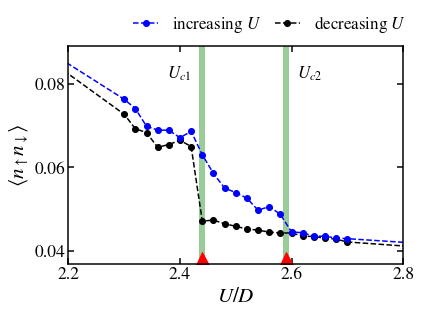

In [4]:
U_c1, U_c2 = 2.44, 2.59
_, docc_up = np.loadtxt('docc_up.txt', unpack=True, dtype = 'float64')
_, docc_dn = np.loadtxt('docc_dn.txt', unpack=True, dtype = 'float64')

plt.axvline(U_c1, c = '#99CC99', lw = '6')
plt.axvline(U_c2, c = '#99CC99', lw = '6')
plt.annotate(r'$U_{c1}$', xy=(0.33, 0.85), xycoords = 'axes fraction', fontsize=17, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.72, 0.85), xycoords = 'axes fraction', fontsize=17, ha='center')

plt.plot(U_dn[1::2], docc_dn[1::2], 'ko--', label=r'decreasing $U$')
plt.plot(U_up[1::2], docc_up[1::2], 'bo--', label=r'increasing $U$')
plt.plot(np.array([U_c1, U_c2]), np.ones(2)*0.038, 'r^', ms=15)
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()
ax.legend([handles[1], handles[0]], [labels[1], labels[0]],bbox_to_anchor=(0.6, 1.1), \
           loc='center', ncol=2, columnspacing = 0.8, fontsize=17)
plt.xlim(2.2,2.8)
plt.ylim(0.037, 0.089)
ax.set_xticks([2.2, 2.4, 2.6, 2.8])
ax.set_yticks([0.04, 0.06, 0.08])
ax.set_ylabel(r'$\langle n_\uparrow n_\downarrow\rangle$', fontsize=21)
ax.set_xlabel(r'$U/D$', fontsize=21)

plt.savefig('fig/fig_docc.pdf')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (9, 9))

im00 = ax[0,0].imshow(model_NN200.encoder.L1.weight.data, cmap='bwr', aspect='auto', **{'vmin':-2.5, 'vmax':2.5})
im10 = ax[0,1].imshow(model_NN200.decoder.L1.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-2.5, 'vmax':2.5})
im01 = ax[1,0].imshow(model_NN200.encoder.L2.weight.data, cmap='bwr', aspect='auto', **{'vmin':-9, 'vmax':9})
im11 = ax[1,1].imshow(model_NN200.decoder.L2.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-9, 'vmax':9})

ca0 = inset_axes(ax[0,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0,1].transAxes, borderpad=0)
ca1 = inset_axes(ax[1,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1,1].transAxes, borderpad=0)
cd = plt.colorbar(im01, cax=ca0)
cd = plt.colorbar(im11, cax=ca1)
plt.savefig('fig/NN200_weight.png')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (9, 9))

im00 = ax[0,0].imshow(model_NN100.encoder.L1.weight.data, cmap='bwr', aspect='auto', **{'vmin':-2.5, 'vmax':2.5})
im10 = ax[0,1].imshow(model_NN100.decoder.L1.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-2.5, 'vmax':2.5})
im01 = ax[1,0].imshow(model_NN100.encoder.L2.weight.data, cmap='bwr', aspect='auto', **{'vmin':-9, 'vmax':9})
im11 = ax[1,1].imshow(model_NN100.decoder.L2.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-9, 'vmax':9})

ca0 = inset_axes(ax[0,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0,1].transAxes, borderpad=0)
ca1 = inset_axes(ax[1,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1,1].transAxes, borderpad=0)
cd = plt.colorbar(im01, cax=ca0)
cd = plt.colorbar(im11, cax=ca1)
plt.savefig('fig/NN100_weight.png')

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (9, 9))

im00 = ax[0,0].imshow(model_NN10.encoder.L1.weight.data, cmap='bwr', aspect='auto', **{'vmin':-0.5, 'vmax':0.5})
im10 = ax[0,1].imshow(model_NN10.decoder.L1.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-2.5, 'vmax':2.5})
im01 = ax[1,0].imshow(model_NN10.encoder.L2.weight.data, cmap='bwr', aspect='auto', **{'vmin':-7.5, 'vmax':7.5})
im11 = ax[1,1].imshow(model_NN10.decoder.L2.weight.data.T, cmap='bwr', aspect='auto', **{'vmin':-7.5, 'vmax':7.5})

ca0 = inset_axes(ax[0,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0,1].transAxes, borderpad=0)
ca1 = inset_axes(ax[1,1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1,1].transAxes, borderpad=0)
cd = plt.colorbar(im01, cax=ca0)
cd = plt.colorbar(im11, cax=ca1)
plt.savefig('fig/NN10_weight.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

im0 = ax[0].imshow(model_LR8.encoder.L1.weight.data, interpolation='none', cmap='bwr', aspect=288/16,\
            **{'vmin':-0.18, 'vmax':0.18})
im1 = ax[1].imshow(model_LR8.decoder.L1.weight.data.T, interpolation='none', cmap='bwr', aspect=288/8,\
            **{'vmin':-3, 'vmax':3})

ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
cd = plt.colorbar(im1, cax=ca1)

plt.savefig('fig/LR8_weight.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

im0 = ax[0].imshow(model_LR4.encoder.L1.weight.data, interpolation='none', cmap='bwr', aspect=288/8,\
            **{'vmin':-0.15, 'vmax':0.15})
im1 = ax[1].imshow(model_LR4.decoder.L1.weight.data.T, interpolation='none', cmap='bwr', aspect=288/4,\
            **{'vmin':-3, 'vmax':3})

ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
cd = plt.colorbar(im1, cax=ca1)

plt.savefig('fig/LR4_weight.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

im0 = ax[0].imshow(model_LR2.encoder.L1.weight.data, interpolation='none', cmap='bwr', aspect=288/4,\
            **{'vmin':-0.3, 'vmax':0.3})
im1 = ax[1].imshow(model_LR2.decoder.L1.weight.data.T, interpolation='none', cmap='bwr', aspect=288/2,\
            **{'vmin':-3, 'vmax':3})

ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
cd = plt.colorbar(im1, cax=ca1)

plt.savefig('fig/LR2_weight.png')